<a href="https://colab.research.google.com/github/FelipeGBarreto/Projects/blob/master/Clusters_Acidentes_BR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLUSTERIZANDO OS ACIDENTES NAS RODOVIAS FEDERAIS DO BRASIL**

# **Método Não Hierárquico**
> Optei pelo um método não hierárquico de análise não supervisionada, devido ao fato de a base de dados ser bem expressiva, o que não performaria bem para um método hierárquico.

**OBJETIVO:** Identificar grupos com características semelhantes com relação a acidentes no Brasil nas rodovias federais, objetivando possíveis políticas de trânsito para atacar e diminuir os acidentes.

## Instalando os pacotes necessários

In [ ]:
pacotes <- c("tidyverse","cluster","dendextend","factoextra","fpc","gridExtra",
             "readxl","ggplot2","tibble")

if(sum(as.numeric(!pacotes %in% installed.packages())) != 0){
  instalador <- pacotes[!pacotes %in% installed.packages()]
  for(i in 1:length(instalador)) {
    install.packages(instalador, dependencies = T)
    break()}
  sapply(pacotes, require, character = T) 
} else {
  sapply(pacotes, require, character = T) 
}

## Utilizando o método k-means

In [2]:
acidentes <- read.table("/content/Acidentes nas Rodovias Federais - 2007 a 2020.txt", sep=";", dec=",", header = T)
head(acidentes)

,id,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,⋯,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,Ordem_Semana,Ano,Mes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,10.0,2007-11-06,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,⋯,0,4,0,5,0,4,6,1,2007,11
2,10.0,2007-11-06,Segunda,15:30:00,MG,381,623.2,OLIVEIRA,Falta de atenção,Colisão frontal,⋯,0,4,0,5,0,4,6,1,2007,11
3,1032898.0,2007-08-13,Segunda,14:25:00,MG,40,585.5,ITABIRITO,Outras,Saída de Pista,⋯,0,0,1,2,0,1,1,1,2007,8
4,1051130.0,2007-12-02,Segunda,02:10:00,MA,135,11.0,SAO LUIS,Animais na Pista,Atropelamento de animal,⋯,2,2,1,0,0,3,1,1,2007,12
5,1066824.0,2007-11-20,Terça,05:30:00,CE,222,30.8,CAUCAIA,Defeito mecânico em veículo,Capotamento,⋯,0,1,0,0,0,1,1,2,2007,11
6,1069918.0,2007-12-16,Domingo,17:40:00,MA,230,14.0,BARAO DE GRAJAU,Outras,Capotamento,⋯,0,0,1,0,0,1,1,7,2007,12


In [17]:
acidentes_t <- acidentes[, c("municipio","pessoas","mortos","feridos_leves","feridos_graves","ilesos","ignorados","feridos","veiculos")]
acidentes_med <- acidentes_t %>% group_by(municipio) %>% summarise(across(everything(), list(sum)))
acidentes_med <- acidentes_med %>% column_to_rownames("municipio")

In [18]:
# Não necessita padronizar a base, mas vou fazer como rotina
acidentes_med_pad <- scale(acidentes_med)

### Rdando de 3 a 6 centros para visualizar qual a melhor divisão a ser feita

In [19]:
municip.k4 <- kmeans(acidentes_med_pad, centers = 4)
municip.k5 <- kmeans(acidentes_med_pad, centers = 5)
municip.k6 <- kmeans(acidentes_med_pad, centers = 6)
municip.k7 <- kmeans(acidentes_med_pad, centers = 7)

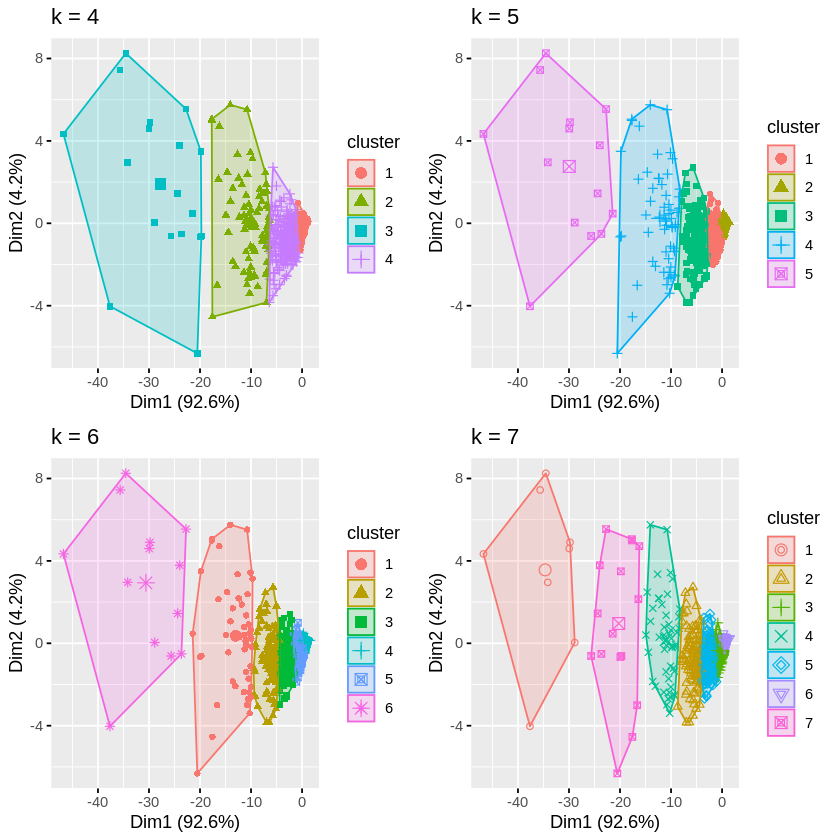

In [20]:
# Verificando visualmente como seriam os clusters
# G <- c()
# for( i in list(municip.k3,municip.k4,municip.k5,municip.k6)){
#   G[i] <- fviz_cluster(i, geom = "point", data = acidentes_med_pad) + ggtitle("k = 3")
# }

G1 <- fviz_cluster(municip.k4, geom = "point", data = acidentes_med_pad) + ggtitle("k = 4")
G2 <- fviz_cluster(municip.k5, geom = "point",  data = acidentes_med_pad) + ggtitle("k = 5")
G3 <- fviz_cluster(municip.k6, geom = "point",  data = acidentes_med_pad) + ggtitle("k = 6")
G4 <- fviz_cluster(municip.k7, geom = "point",  data = acidentes_med_pad) + ggtitle("k = 7")
grid.arrange(G1, G2, G3, G4, nrow = 2)

### Verificando possíveis quantidades de clusters com o método Elbow

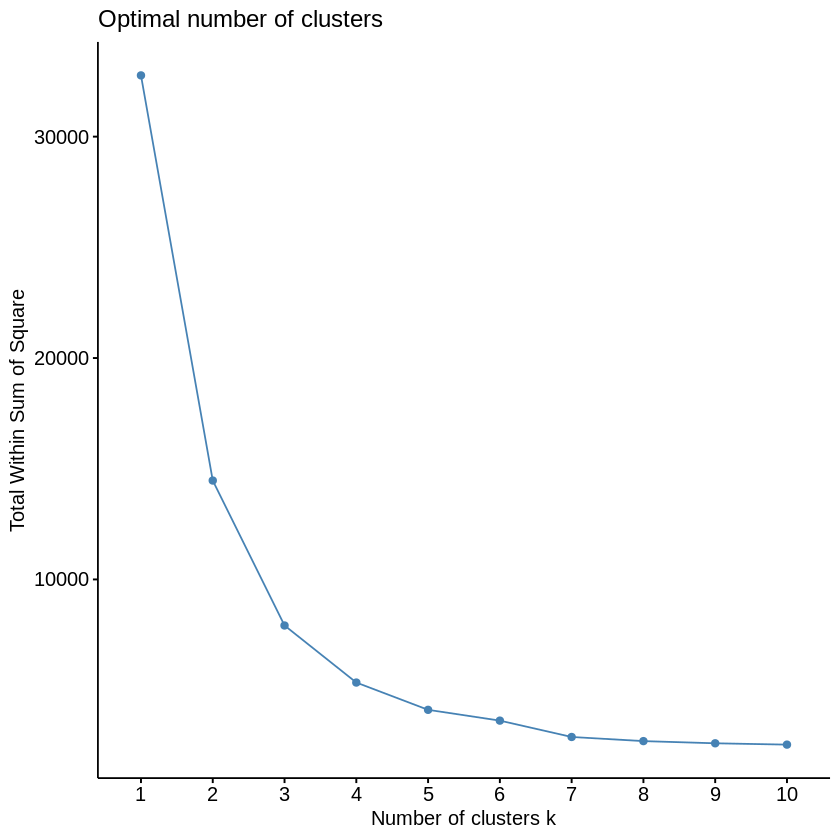

In [21]:
fviz_nbclust(acidentes_med_pad, kmeans, method = "wss")# Como o método é o não hierárquico, o método deve ser pelo kmeans

- Analisando a variabilidade, secolhemos 7 grupos para trabalhar

### Juntando os dados

In [22]:
acidentes_med <- cbind(acidentes_med, data.frame(municip.k7$cluster))

### Análise dos 7 clusters criados

In [23]:
# Médias por grupo
grupos <- acidentes_med %>% group_by("Grupos" = municip.k7.cluster) %>% summarise("Quantidade"=n() ,across(everything(), list(mean)))
grupos <- grupos[, c(1:10)]
grupos

Grupos,Quantidade,pessoas_1_1,mortos_1_1,feridos_leves_1_1,feridos_graves_1_1,ilesos_1_1,ignorados_1_1,feridos_1_1,veiculos_1_1
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8,41212.2500,433.250000,8394.12500,2202.00000,28083.25000,2098.000000,10596.12500,35403.25000
2,111,6839.6396,136.108108,1569.89189,513.91892,4333.79279,285.774775,2083.81081,5491.66667
3,615,1175.8081,44.673171,303.44065,117.89593,662.67317,47.112195,421.33659,850.36748
4,50,13529.3200,188.420000,2710.64000,846.50000,9212.38000,571.000000,3557.14000,11540.00000
5,255,3169.8667,89.670588,775.04314,291.70588,1893.17647,120.176471,1066.74902,2409.47451
6,3042,121.2531,5.228139,35.37936,12.68212,62.34911,5.613741,48.06147,84.15976
7,16,23841.1250,298.625000,4339.31250,1628.93750,16376.62500,1196.875000,5968.25000,20947.18750


In [30]:
acidentes_med[acidentes_med$municip.k7.cluster == 1, ]

,pessoas_1,mortos_1,feridos_leves_1,feridos_graves_1,ilesos_1,ignorados_1,feridos_1,veiculos_1,municip.k7.cluster
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
BETIM,40373,322,7187,1773,29950,1137,8960,35810,1
BRASILIA,38047,660,11302,2786,21316,1981,14088,28260,1
CURITIBA,54579,604,10869,3018,37207,2880,13887,47677,1
DUQUE DE CAXIAS,38718,428,6759,1356,28351,1822,8115,33121,1
GUARULHOS,41174,447,8712,1099,27614,3301,9811,36960,1
PORTO VELHO,32537,402,7689,2244,20603,1599,9933,24546,1
SAO JOSE,44643,203,9133,2013,31492,1800,11146,41218,1
SERRA,39627,400,5502,3327,28133,2264,8829,35634,1
